# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [461]:
class Constant:
    n_questions = 120
    n_answers = 4
    n_students = 100
    max_correction_epochs= 10
    smartness_avg = 0.25
    smartness_std = 0.1

def print_constants():
    print("n_questions:", Constant.n_questions)
    print("n_answers:", Constant.n_answers)
    print("n_students:", Constant.n_students)
    print("max_correction_epochs:", Constant.max_correction_epochs)
    print("smartness_avg:", Constant.smartness_avg)
    print("smartness_std:", Constant.smartness_std)

# simulation

In [67]:
def get_answer_sheet():
    return np.random.randint(0, Constant.n_answers, Constant.n_questions)

answers = get_answer_sheet()

In [514]:
def get_student_answer_sheet():
    return np.random.randint(0, Constant.n_answers, Constant.n_questions)

def get_answer_matrix():
    answer_matrix = np.zeros((Constant.n_students, Constant.n_questions),dtype=np.int8)
    for i in range(Constant.n_students):
        answer_matrix[i] = get_student_answer_sheet()
    return answer_matrix

def get_student_answer_sheet_assuming_smart(smartness: float, answers):
    student_answers = np.zeros(Constant.n_questions,dtype=np.int8)
    for i in range(Constant.n_questions):
        if np.random.rand() < smartness:
            student_answers[i] = answers[i]
        else:
            student_answers[i] = np.random.randint(0, Constant.n_answers)
    return student_answers

def get_answer_matrix_assuming_smart(answers, average_smartness:float = Constant.smartness_avg, smartness_std:float = Constant.smartness_std):
    answer_matrix = np.zeros((Constant.n_students, Constant.n_questions),dtype=np.int8)
    for i in range(Constant.n_students):
        smartness = np.random.normal(average_smartness, smartness_std)
        smartness = max(0, min(0.98, smartness))
        answer_matrix[i] = get_student_answer_sheet_assuming_smart(smartness, answers)
    return answer_matrix

answer_matrix = get_answer_matrix()

In [69]:
def get_student_score(student_answers, answer_sheet):
    return np.sum(student_answers == answer_sheet)

def get_score_list(answer_matrix, answer_sheet):
    score_list = np.zeros(Constant.n_students)
    for i in range(Constant.n_students):
        score_list[i] = get_student_score(answer_matrix[i], answer_sheet)/Constant.n_questions
    return score_list

score_list = get_score_list(answer_matrix, answers)

# inference

In [70]:
def get_probability_matrix(score_list, answer_matrix):
    probability_matrix = np.zeros((Constant.n_questions, Constant.n_answers))
    for i in range(Constant.n_questions):
        for j in range(Constant.n_answers):
            for k in range(Constant.n_students):
                probability_matrix[i, j] += score_list[k] * (answer_matrix[k, i] == j) + (1-score_list[k]) * (answer_matrix[k, i] != j) / (Constant.n_answers - 1)
    return probability_matrix

In [71]:
def get_argmaxes(probability_matrix):
    argmaxes = np.zeros(Constant.n_questions)
    for i in range(Constant.n_questions):
        argmaxes[i] = np.argmax(probability_matrix[i])
    argmaxes = np.array(argmaxes, dtype=int)
    return argmaxes

In [72]:
predictions = get_argmaxes(get_probability_matrix(score_list,answer_matrix))

# Evaluation

In [73]:
def evaluate(prediction,groud_truth):
    return np.sum(prediction == groud_truth)/Constant.n_questions

In [74]:
evaluate(predictions,answers)

0.5916666666666667

# visuals

In [75]:
def show_answers(sheet):
    sheet_matrix = np.zeros((Constant.n_questions, Constant.n_answers))
    for i in range(Constant.n_questions):
        sheet_matrix[i, sheet[i]] = 1
    plt.imshow(sheet_matrix, cmap='gray')

In [657]:
def compare_sheets(predictions, groud_truth):
    plt.figure(figsize=(4,10))
    plt.subplot(1,3,1)
    plt.title("predictions")
    show_answers(predictions)
    plt.subplot(1,3,2)
    plt.title("groud_truth")
    show_answers(groud_truth)
    plt.subplot(1,3,3)
    plt.title('Correct')
    comparison = predictions == groud_truth
    comparison = comparison.reshape((-1,1))
    plt.imshow(comparison, cmap='RdYlGn')
    # plt.show()

(120, 1)


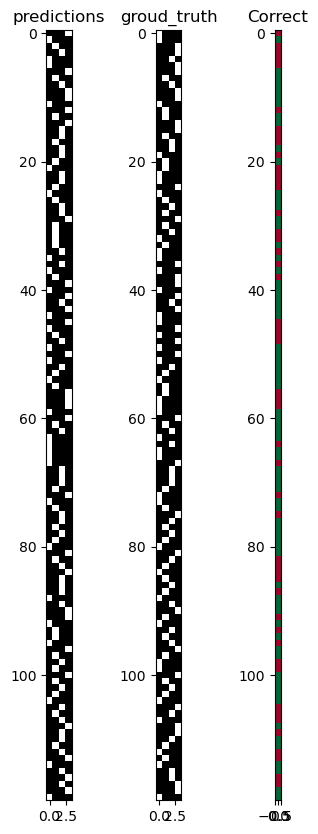

In [120]:
compare_sheets(predictions, answers)

# All at ones

In [187]:
Constant.n_questions = 120
Constant.n_answers = 4
Constant.n_students = 1000

0.975


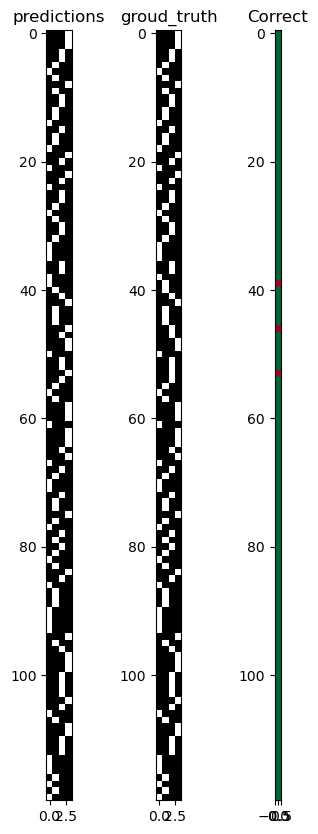

In [216]:
answers = get_answer_sheet()
answer_matrix = get_answer_matrix()
score_list = get_score_list(answer_matrix, answers)
probability_matrix = get_probability_matrix(score_list,answer_matrix)
predictions = get_argmaxes(probability_matrix)
print(evaluate(predictions,answers))
compare_sheets(predictions, answers)

# Correction

In [189]:
def get_validity_distance_list(predictions, score_list, answer_matrix):
    validity_list = np.zeros(Constant.n_students,dtype=int)
    for i in range(Constant.n_students):
        student_answers = answer_matrix[i]
        validity_list[i] = round(abs(get_student_score(student_answers, predictions)/Constant.n_questions - score_list[i]) * Constant.n_questions,0)
    return validity_list

In [191]:
validity_list = get_validity_distance_list(predictions, score_list, answer_matrix)

In [218]:
max_epochs = 10

In [467]:
def try_changes(predictions, score_list, answer_matrix):
    start_distance = np.sum(get_validity_distance_list(predictions, score_list, answer_matrix))
    #print("start_distance: ", start_distance)
    for epoch in range(Constant.max_correction_epochs):
        for i in range(Constant.n_questions):
            backup = predictions[i]
            distance_changed = False
            for j in range(Constant.n_answers):
                predictions[i] = j
                distance = np.sum(get_validity_distance_list(predictions, score_list, answer_matrix))
                if distance < start_distance:
                    start_distance = distance
                    distance_changed = True
                    #print("distance: ", distance)
                    break
                else:
                    predictions[i] = (j+1)%Constant.n_answers
            if not distance_changed:
                predictions[i] = backup
            elif start_distance == 0:
                return predictions
    return predictions

In [589]:
def get_uncertainty_priority_list(probability_matrix):
    stdlist = [[0,i] for i in range(Constant.n_questions)]
    for i in range(Constant.n_questions):
        stdlist[i][0] = np.std(probability_matrix[i])
    stdlist.sort()
    priority_list = [x[1] for x in stdlist]
    return priority_list

def try_changes_with_priority_to_least_known_answers(predictions, score_list, answer_matrix, priority_list):
    start_distance = np.sum(get_validity_distance_list(predictions, score_list, answer_matrix))
    #print("start_distance: ", start_distance)
    for epoch in range(Constant.max_correction_epochs):
        #print("epoch: ", epoch)
        for i in priority_list:
            backup = predictions[i]
            distance_changed = False
            for j in range(Constant.n_answers):
                predictions[i] = j
                distance = np.sum(get_validity_distance_list(predictions, score_list, answer_matrix))
                if distance < start_distance:
                    start_distance = distance
                    distance_changed = True
                    #print("distance: ", distance)
                    break
                else:
                    predictions[i] = (j+1)%Constant.n_answers
            if not distance_changed:
                predictions[i] = backup
            elif start_distance == 0:
                return predictions
    return predictions

In [643]:
def multi_desendant_mutation(predictions, score_list, answer_matrix, priority_list,n_desendants=2):       #TODO
    start_distance = [np.sum(get_validity_distance_list(predictions, score_list, answer_matrix)) for i in range(n_desendants)]
    desendants = [predictions.copy() for i in range(n_desendants)]
    print("start_distance: ", start_distance[0])
    for epoch in range(Constant.max_correction_epochs):
        print("epoch: ", epoch)
        for k, descendant in enumerate(desendants):
            for i in priority_list:
                backup = descendant[i]
                distance_changed = False
                if np.random.rand() > 0.5:
                    for j in range(Constant.n_answers):
                        descendant[i] = j
                        distance = np.sum(get_validity_distance_list(descendant, score_list, answer_matrix))
                        if distance < start_distance[k]:
                            start_distance[k] = distance
                            distance_changed = True
                            break
                        else:
                            descendant[i] = (j+1)%Constant.n_answers
                    if not distance_changed:
                        descendant[i] = backup
                    elif start_distance[k] == 0:
                        print("done")
                        return descendant
            print("distance: ", start_distance[k])
        aux = [[start_distance[i],i] for i in range(len(start_distance))]
        aux.sort()
        keep = [x[1] for x in aux[:n_desendants//2]]
        desendants = [desendants[i] for i in keep]*2
        start_distance = [start_distance[i] for i in keep]*2
    return desendants[0]

In [219]:
new_predictions = try_changes(predictions, score_list, answer_matrix)

start_distance:  934
distance:  743
distance:  520
distance:  504
distance:  0


In [211]:
evaluate(predictions, answers)

1.0

In [647]:
Constant.n_questions = 120
Constant.n_answers = 4
Constant.n_students = 300
Constant.max_correction_epochs= 10
Constant.smartness_avg = 0.0
Constant.smartness_std = 0.0

avg scores:  0.24716666666666667
min scores:  0.14166666666666666
max scores:  0.375
score:  0.75
start_distance:  874
epoch:  0
distance:  699
distance:  688
distance:  727
distance:  670
distance:  676
distance:  615
distance:  661
distance:  719
distance:  661
distance:  702
epoch:  1
distance:  540
distance:  606
distance:  650
distance:  608
distance:  654
distance:  487
distance:  599
distance:  583
distance:  590
distance:  604
epoch:  2
distance:  463
distance:  406
distance:  554
distance:  547
distance:  588
distance:  353
distance:  320
distance:  544
distance:  506
distance:  556
epoch:  3
distance:  264
distance:  211
distance:  140
distance:  224
distance:  490
distance:  224
distance:  266
distance:  219
distance:  219
distance:  417
epoch:  4
distance:  140
distance:  211
distance:  219
distance:  219
distance:  145
distance:  140
distance:  145
distance:  145
distance:  145
distance:  215
epoch:  5
distance:  140
distance:  140
distance:  145
distance:  145
distance:  

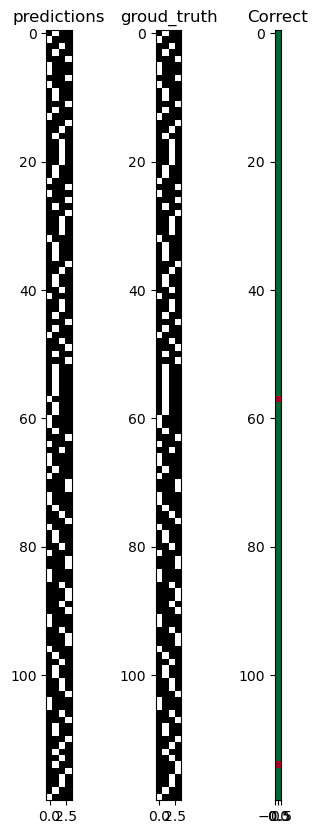

In [649]:
answers = get_answer_sheet()
answer_matrix = get_answer_matrix_assuming_smart(answers,Constant.smartness_avg,Constant.smartness_std)
score_list = get_score_list(answer_matrix, answers)
print("avg scores: ", np.mean(score_list))
print("min scores: ", np.min(score_list))
print("max scores: ", np.max(score_list))
probability_matrix = get_probability_matrix(score_list,answer_matrix)
predictions = get_argmaxes(probability_matrix)
print("score: ", evaluate(predictions,answers))
#compare_sheets(predictions, answers)
distance = np.sum(get_validity_distance_list(predictions, score_list, answer_matrix))
if distance > 0:
    priority_list = get_uncertainty_priority_list(probability_matrix)
    new_predictions = multi_desendant_mutation(predictions, score_list, answer_matrix,priority_list,n_desendants=10)
    print("score: ", evaluate(new_predictions, answers))
    compare_sheets(new_predictions, answers)

# Benchmarking

In [491]:
def benchmark(epochs = 10):
    print_constants()
    one_shot = 0
    final = 0
    for e in range(epochs):
        #simulation
        answers = get_answer_sheet()
        answer_matrix = get_answer_matrix_assuming_smart(answers,0.25,0.1)
        #inference
        score_list = get_score_list(answer_matrix, answers)
        probability_matrix = get_probability_matrix(score_list,answer_matrix)
        predictions = get_argmaxes(probability_matrix)

        one_shot += evaluate(predictions,answers)/epochs

        distance = np.sum(get_validity_distance_list(predictions, score_list, answer_matrix))
        if distance > 0:
            priority_list = get_uncertainty_priority_list(probability_matrix)
            new_predictions = try_changes_with_priority_to_least_known_answers(predictions, score_list, answer_matrix,priority_list)
            final += evaluate(new_predictions, answers)/epochs
        else:
            final += evaluate(predictions, answers)/epochs
            
    print("one-shot: ", round(one_shot,3))
    print("\033[1mfinal: \033[0m", round(final,3))
    return final


In [588]:
n_students = [10,20,30,40,50,60,70,80,90,100,110,120]
n_answers = [3,4,5]
smartness_avg = [0.0,0.1,0.25,0.5,0.75]
smartness_std = [0.0,0.1,0.2]

In [495]:
n_students_y = []
n_answers_y = []
smartness_avg_y = []
smartness_std_y = []

Constant.n_questions = 120
Constant.n_answers = 4
Constant.n_students = 100
Constant.max_correction_epochs= 10
Constant.smartness_avg = 0.25
Constant.smartness_std = 0.1


for v in n_students:
    Constant.n_students = v
    n_students_y.append(benchmark(20))
    print()
print("#############################################")
print()
"""
for v in n_answers:
    Constant.n_answers = v
    n_answers_y.append(benchmark(20))
    print()
Constant.n_answers = 4
print("#############################################")
print()
for v in smartness_avg:
    Constant.smartness_avg = v
    smartness_avg_y.append(benchmark(20))
    print()
Constant.smartness_avg = 0.25
print("#############################################")
print()
for v in smartness_std:
    Constant.smartness_std = v
    smartness_std_y.append(benchmark(20))
    print()
Constant.smartness_std = 0.1
print("#############################################")
print()
"""

n_questions: 120
n_answers: 4
n_students: 10
max_correction_epochs: 10
smartness_avg: 0.25
smartness_std: 0.1
one-shot:  0.745
final:  0.668

n_questions: 120
n_answers: 4
n_students: 20
max_correction_epochs: 10
smartness_avg: 0.25
smartness_std: 0.1
one-shot:  0.889
final:  0.853

n_questions: 120
n_answers: 4
n_students: 30
max_correction_epochs: 10
smartness_avg: 0.25
smartness_std: 0.1
one-shot:  0.94
final:  0.93

n_questions: 120
n_answers: 4
n_students: 40
max_correction_epochs: 10
smartness_avg: 0.25
smartness_std: 0.1
one-shot:  0.962
final:  0.98

n_questions: 120
n_answers: 4
n_students: 50
max_correction_epochs: 10
smartness_avg: 0.25
smartness_std: 0.1
one-shot:  0.988
final:  0.998

n_questions: 120
n_answers: 4
n_students: 60
max_correction_epochs: 10
smartness_avg: 0.25
smartness_std: 0.1
one-shot:  0.994
final:  0.999

n_questions: 120
n_answers: 4
n_students: 70
max_correction_epochs: 10
smartness_avg: 0.25
smartness_std: 0.1
one-shot:  0.996
final:  1.0

n_questions

'\nfor v in n_answers:\n    Constant.n_answers = v\n    n_answers_y.append(benchmark(20))\n    print()\nConstant.n_answers = 4\nprint("#############################################")\nprint()\nfor v in smartness_avg:\n    Constant.smartness_avg = v\n    smartness_avg_y.append(benchmark(20))\n    print()\nConstant.smartness_avg = 0.25\nprint("#############################################")\nprint()\nfor v in smartness_std:\n    Constant.smartness_std = v\n    smartness_std_y.append(benchmark(20))\n    print()\nConstant.smartness_std = 0.1\nprint("#############################################")\nprint()\n'

In [496]:
n_students_y

[0.6683333333333334,
 0.8533333333333334,
 0.9299999999999999,
 0.9800000000000002,
 0.997916666666667,
 0.9987500000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002]

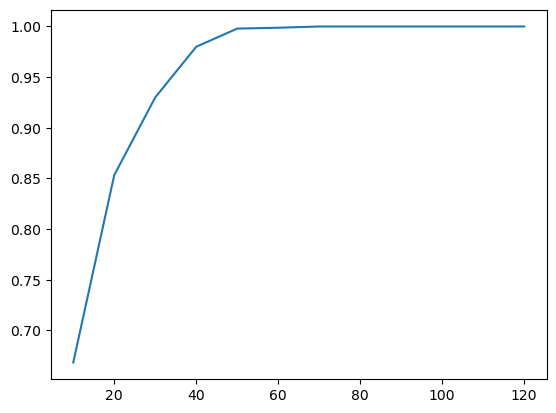

In [497]:
plt.plot(n_students, n_students_y)

In [664]:
def compare_sheets_heatmap(probability_matrix, groud_truth):
    plt.figure(figsize=(4,10))
    plt.subplot(1,3,1)
    plt.title("predictions")
    plt.imshow(probability_matrix, cmap='gray')
    plt.subplot(1,3,2)
    plt.title("groud_truth")
    show_answers(groud_truth)
    plt.subplot(1,3,3)
    plt.title('Correct')
    comparison = predictions == groud_truth
    comparison = comparison.reshape((-1,1))
    plt.imshow(comparison, cmap='RdYlGn')
    # plt.show()

(2000, 120)
(200, 120)
(400, 120)
(600, 120)
(800, 120)
(1000, 120)
(1200, 120)
(1400, 120)
(1600, 120)
(1800, 120)
(2000, 120)


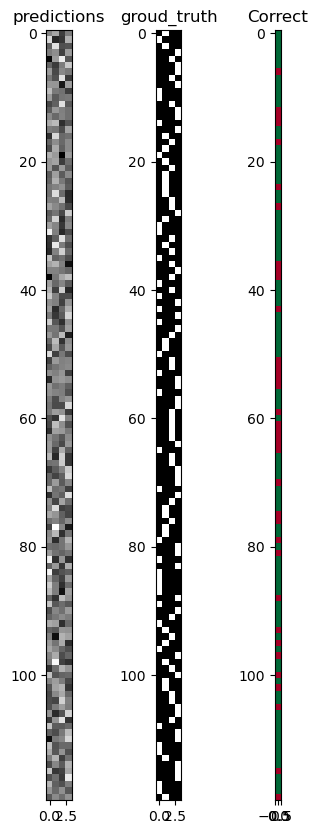

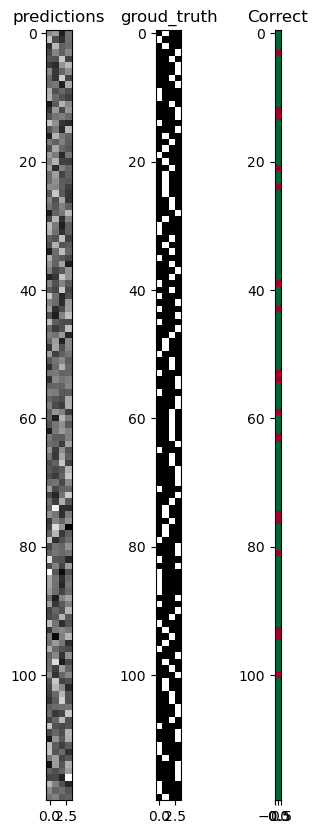

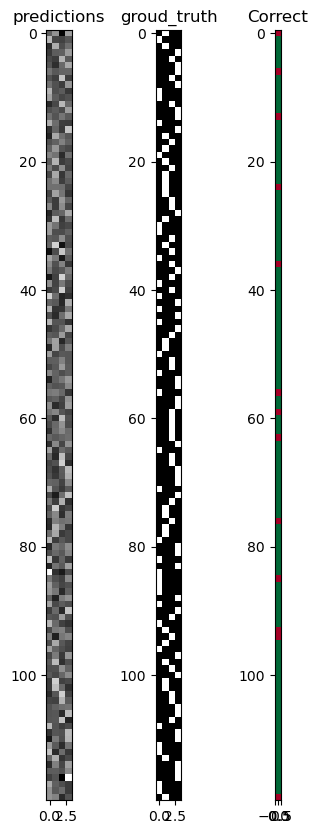

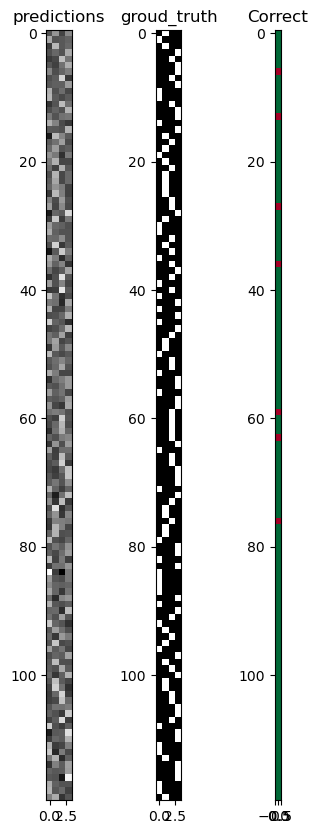

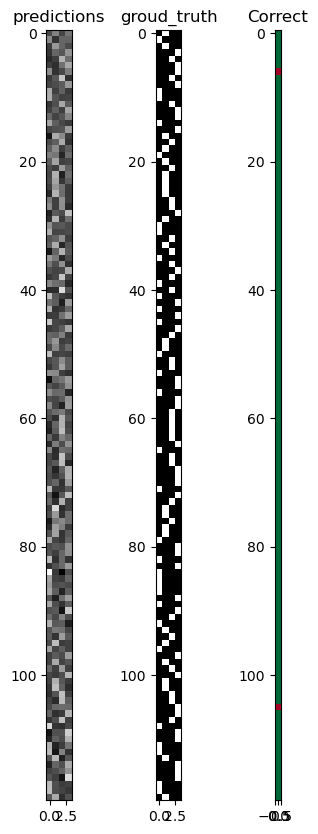

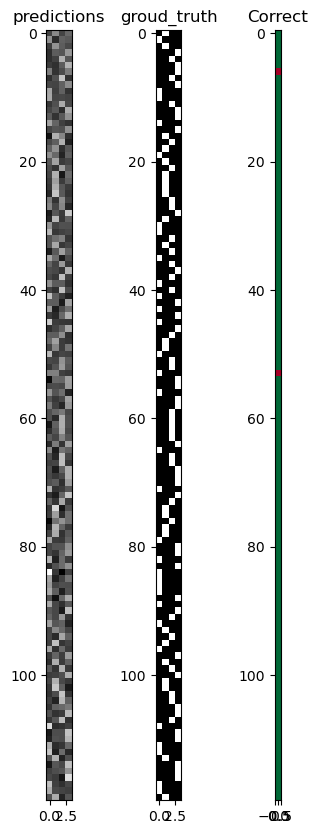

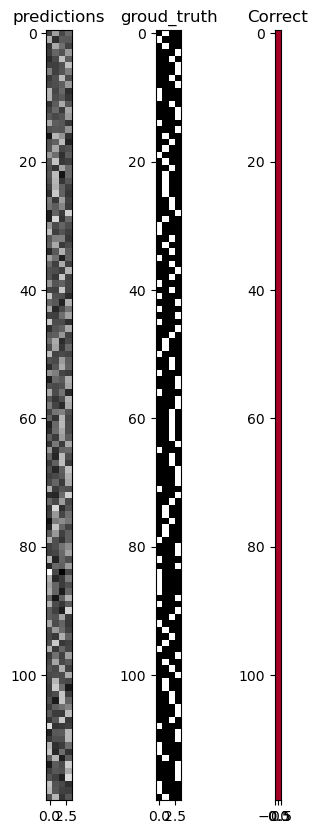

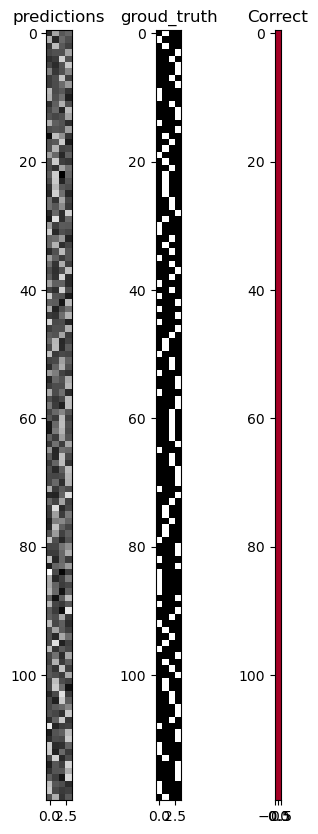

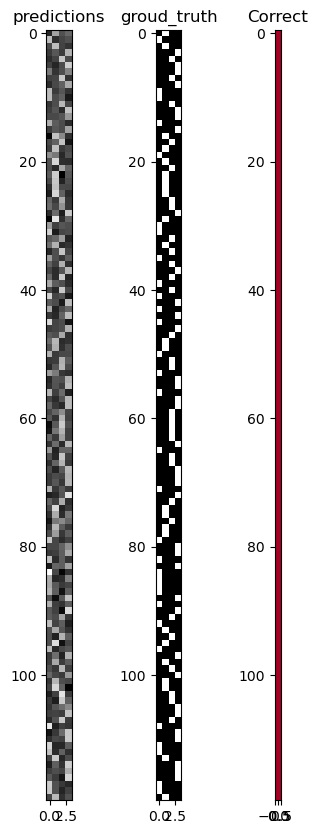

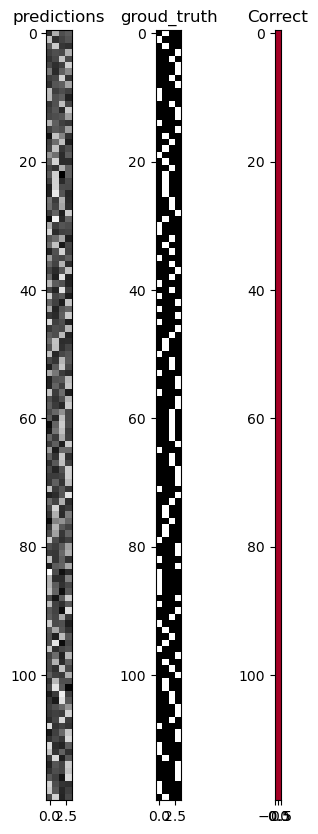

In [674]:
Constant.n_questions = 120
Constant.n_answers = 4
Constant.n_students = 2000
Constant.max_correction_epochs= 10
Constant.smartness_avg = 0.0
Constant.smartness_std = 0.0

steps = 10
stepsize = Constant.n_students//steps
answers = get_answer_sheet()
answer_matrix = get_answer_matrix_assuming_smart(answers,Constant.smartness_avg,Constant.smartness_std)
print(answer_matrix.shape)
for i in range(steps):
    Constant.n_students = stepsize*(i+1)
    partial_answer_matrix = answer_matrix[:stepsize*(i+1),:]
    print(partial_answer_matrix.shape)
    score_list = get_score_list(partial_answer_matrix, answers)
    probability_matrix = get_probability_matrix(score_list,partial_answer_matrix)
    predictions = get_argmaxes(probability_matrix)
    compare_sheets_heatmap(probability_matrix, answers)
    plt.savefig("plot"+str(i)+".png")
